
# Predicting Air Pollution Levels using a Ridge Regression

This notebook demonstrates the steps to use a Ridge Regression model to predict air pollution levels.

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV


In [2]:
full_data = pd.read_csv("prepped_data/Full_data.csv") 
full_data.columns

Index(['Hour', 'date', 'NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3',
       'PM25_ugm3', 'SiteID', 'Lat', 'Long', 'day_of_week', 'avgtempC',
       'maxtempC', 'mintempC', 'sunHour', 'uvIndex', 'humidity',
       'winddirDegree', 'windspeedKmph', 'cloudcover', 'precipMM', 'pressure',
       'DCC-AQ1-co', 'DCC-AQ1-no', 'DCC-AQ10-no', 'DCC-AQ13-no', 'DCC-AQ5-no',
       'DCC-AQ6-no', 'DCC-AQ1-no2', 'DCC-AQ10-no2', 'DCC-AQ13-no2',
       'DCC-AQ22-no2', 'DCC-AQ5-no2', 'DCC-AQ6-no2', 'DCC-AQ69-no2',
       'DCC-AQ22-o3', 'DCC-AQ69-o3', 'DCC-AQ10-pm1', 'DCC-AQ13-pm1',
       'DCC-AQ2-pm1', 'DCC-AQ3-pm1', 'DCC-AQ4-pm1', 'DCC-AQ5-pm1',
       'DCC-AQ52-pm1', 'DCC-AQ6-pm1', 'TNO2161-pm1', 'TNO2162-pm1',
       'TNO4435-pm1', 'TNT1088-pm1', 'DCC-AQ10-pm10', 'DCC-AQ13-pm10',
       'DCC-AQ2-pm10', 'DCC-AQ22-pm10', 'DCC-AQ3-pm10', 'DCC-AQ4-pm10',
       'DCC-AQ5-pm10', 'DCC-AQ52-pm10', 'DCC-AQ6-pm10', 'TNO2161-pm10',
       'TNO2162-pm10', 'TNO4435-pm10', 'TNT1088-pm10', 'DCC-AQ10-pm2_

In [3]:
df_test = full_data[full_data['date'] >= '2022-05-01']
df_train = full_data[full_data['date'] < '2022-05-01']

In [4]:
# #Split train into X and Y
Xtrain = df_train.iloc[:, 8:].values
ytrain = df_train["PM25_ugm3"].values

# #Split test into X and Y
Xtest = df_test.iloc[:, 8:].values
ytest = df_test["PM25_ugm3"].values


In [5]:
print(Xtrain.shape)
print(ytrain.shape) 
print(Xtest.shape)
print(ytest.shape)

(34923, 84)
(34923,)
(8272, 84)
(8272,)


In [6]:
# Assuming you know the names of the categorical columns
categorical_columns = ['SiteID', 'day_of_week']  # List of categorical column names

# Convert arrays back to DataFrame for easier manipulation
Xtrain_df = pd.DataFrame(Xtrain, columns=df_train.columns[8:])
Xtest_df = pd.DataFrame(Xtest, columns=df_test.columns[8:])

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit the encoder on the training data
encoder.fit(Xtrain_df[categorical_columns])

# Transform both training and test data
Xtrain_encoded = encoder.transform(Xtrain_df[categorical_columns])
Xtest_encoded = encoder.transform(Xtest_df[categorical_columns])

# Create DataFrames from the encoded arrays, include column names for easier merging
encoded_columns = encoder.get_feature_names_out(categorical_columns)
Xtrain_encoded_df = pd.DataFrame(Xtrain_encoded, columns=encoded_columns)
Xtest_encoded_df = pd.DataFrame(Xtest_encoded, columns=encoded_columns)

# Drop the original categorical columns and concat the new encoded columns
Xtrain_final = pd.concat([Xtrain_df.drop(categorical_columns, axis=1), Xtrain_encoded_df], axis=1)
Xtest_final = pd.concat([Xtest_df.drop(categorical_columns, axis=1), Xtest_encoded_df], axis=1)


c:\Users\Giulia Maria\miniconda3\envs\ML\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
print(Xtrain_final.shape)
print(ytrain.shape) 
print(Xtest_final.shape)
print(ytest.shape)

(34923, 901)
(34923,)
(8272, 901)
(8272,)


In [8]:
print(Xtrain_final.columns)
print(Xtest_final.columns)


Index(['Lat', 'Long', 'avgtempC', 'maxtempC', 'mintempC', 'sunHour', 'uvIndex',
       'humidity', 'winddirDegree', 'windspeedKmph',
       ...
       'SiteID_964.0', 'SiteID_965.0', 'SiteID_968.0', 'SiteID_974.0',
       'SiteID_1002.0', 'day_of_week_0.0', 'day_of_week_1.0',
       'day_of_week_2.0', 'day_of_week_3.0', 'day_of_week_4.0'],
      dtype='object', length=901)
Index(['Lat', 'Long', 'avgtempC', 'maxtempC', 'mintempC', 'sunHour', 'uvIndex',
       'humidity', 'winddirDegree', 'windspeedKmph',
       ...
       'SiteID_964.0', 'SiteID_965.0', 'SiteID_968.0', 'SiteID_974.0',
       'SiteID_1002.0', 'day_of_week_0.0', 'day_of_week_1.0',
       'day_of_week_2.0', 'day_of_week_3.0', 'day_of_week_4.0'],
      dtype='object', length=901)


In [9]:
np.random.seed(0)   
# imputing 
imputer = SimpleImputer(strategy="mean")
Xtrain_1 = imputer.fit_transform(Xtrain_final)  # Impute
Xtest_1 = imputer.transform(Xtest_final)  # Impute

# Convert back to DataFrame
Xtrain_1 = pd.DataFrame(Xtrain_1, columns=Xtrain_final.columns)
Xtest_1 = pd.DataFrame(Xtest_1, columns=Xtest_final.columns)

# scaling 
scaler = StandardScaler()
Xtrain_1 = scaler.fit_transform(Xtrain_1)  # Scale
Xtest_1 = scaler.transform(Xtest_1)  # Scale

# Convert back to DataFrame
Xtrain_1 = pd.DataFrame(Xtrain_1, columns=Xtrain_final.columns)
Xtest_1 = pd.DataFrame(Xtest_1, columns=Xtest_final.columns)


Scaling and imputing

In [10]:
print(Xtrain_1.columns)
print(Xtest_1.columns)


Index(['Lat', 'Long', 'avgtempC', 'maxtempC', 'mintempC', 'sunHour', 'uvIndex',
       'humidity', 'winddirDegree', 'windspeedKmph',
       ...
       'SiteID_964.0', 'SiteID_965.0', 'SiteID_968.0', 'SiteID_974.0',
       'SiteID_1002.0', 'day_of_week_0.0', 'day_of_week_1.0',
       'day_of_week_2.0', 'day_of_week_3.0', 'day_of_week_4.0'],
      dtype='object', length=901)
Index(['Lat', 'Long', 'avgtempC', 'maxtempC', 'mintempC', 'sunHour', 'uvIndex',
       'humidity', 'winddirDegree', 'windspeedKmph',
       ...
       'SiteID_964.0', 'SiteID_965.0', 'SiteID_968.0', 'SiteID_974.0',
       'SiteID_1002.0', 'day_of_week_0.0', 'day_of_week_1.0',
       'day_of_week_2.0', 'day_of_week_3.0', 'day_of_week_4.0'],
      dtype='object', length=901)


In [11]:
print(Xtrain_1.shape)
#print(ytrain.shape) 
print(Xtest_1.shape)
#print(ytest.shape)

(34923, 901)
(8272, 901)


Model Definition

In [12]:
ridge_model = Ridge(alpha=1.0)

print(Xtrain_1)
#type(Xtrain_1)
total_nas = np.isnan(Xtrain).sum()
print(f"Total number of missing values in the array: {total_nas}")


            Lat      Long  avgtempC  maxtempC  mintempC   sunHour   uvIndex  \
0     -1.128775 -1.358738 -1.330213 -1.137422 -1.953354  0.900165 -0.207077   
1     -0.759257 -1.584956 -1.330213 -1.137422 -1.953354  0.900165 -0.207077   
2     -1.188387 -1.714836 -1.330213 -1.137422 -1.953354  0.900165 -0.207077   
3     -1.048941 -2.050665 -1.330213 -1.137422 -1.953354  0.900165 -0.207077   
4     -2.137602 -1.135172 -1.330213 -1.137422 -1.953354  0.900165 -0.207077   
...         ...       ...       ...       ...       ...       ...       ...   
34918 -0.132409 -1.337824 -0.546162 -0.400707 -0.684064  0.900165 -0.207077   
34919 -0.435661 -1.567350 -0.546162 -0.400707 -0.684064  0.900165 -0.207077   
34920 -0.421234 -2.373674 -0.546162 -0.400707 -0.684064  0.900165 -0.207077   
34921 -0.425282 -1.900000 -0.546162 -0.400707 -0.684064  0.900165 -0.207077   
34922 -0.251402 -1.331211 -0.546162 -0.400707 -0.684064  0.900165 -0.207077   

       humidity  winddirDegree  windspeedKmph  ... 

Fit the model

In [13]:
ridge_model.fit(Xtrain_1, ytrain)



Ridge()

Evaluation

In [15]:
ypred = ridge_model.predict(Xtest_1)  # Predict on the test data
mse = mean_squared_error(ytest, ypred)  # Calculate the mean squared error
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 35.688674850183666


Tuning

In [18]:
param_grid = {'alpha': [0.1, 1, 10, 100]}
search = GridSearchCV(Ridge(), param_grid, cv=5)  # 5-fold cross-validation
search.fit(Xtrain_1, ytrain)
print(f"Best parameters: {search.best_params_}")


Best parameters: {'alpha': 100}


Repeat the analysis with best params

In [19]:
# Initialize the Ridge Regression model with the best alpha
ridge_model = Ridge(alpha=100)

# Fit the model on the training data
ridge_model.fit(Xtrain_1, ytrain) 

Ridge(alpha=100)

In [20]:
ypred = ridge_model.predict(Xtest_1)  # Predict on the test data
mse = mean_squared_error(ytest, ypred)  # Calculate the mean squared error
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 33.195137652639865


To calculate the final Mean Squared Error (MSE) on the test set using the best alpha value identified from the validation set, we follow the steps ahead. This will give us an estimate of how well your Ridge Regression model is expected to perform on unseen data.

Combine Training and Validation Sets For the final model, you'll use both the training and validation data to train it, maximizing the amount of data the model can learn from.

Evaluation

To calculate the final Mean Squared Error (MSE) on the test set using the best alpha value identified from the validation set, we follow the steps ahead. This will give us an estimate of how well your Ridge Regression model is expected to perform on unseen data.

Combine Training and Validation Sets For the final model, you'll use both the training and validation data to train it, maximizing the amount of data the model can learn from.

The data has been imputed and scaled already. 

In [ ]:

Xtest_KNN = pd.read_csv('prepped_data/Xtest_KNN.csv')
Xtest = pd.read_csv('prepped_data/Xtest.csv')
Xtrain_KNN = pd.read_csv('prepped_data/Xtrain_KNN.csv')
Xtrain = pd.read_csv('prepped_data/Xtrain.csv')

# Load testing data
ytest = pd.read_csv('prepped_data/ytest.csv')
ytrain = pd.read_csv('prepped_data/ytrain.csv')    


In [ ]:
Xtest.head()





,-1.265442357359503500e+00,1.082513882083443235e+00,2.118512881063047415e-01,-6.763974937517387431e-01,2.378892478390954579e-01,-1.551355423057182437e-01,5.852262044017836340e-01,-1.468188823401546550e+00,-2.070769286339330106e-01,8.983606759475268877e-01,...,9.054891287401285738e-02,4.528703334896053700e-01,-2.998185995893082323e-01,-5.009153328470787869e-01,1.075787876666744580e+00,-2.030716628485772501e-01,-1.281888430278194324e+00,-6.510714298405980183e-17,-9.035034288202553610e-01,7.321839844486313087e-01
0,1.349344,0.051100,0.741105,-0.676397,0.237889,-0.155136,0.585226,-1.468189,-0.207077,1.124375,...,0.237822,0.725261,-0.255249,-0.630528,1.115145,-0.180724,-1.108769,-6.510714e-17,-0.749681,-1.247859e+00
1,-0.635895,-0.543513,0.491428,-0.676397,0.237889,-0.155136,0.585226,-1.468189,-0.207077,0.785354,...,0.700680,-0.154660,-0.359245,-0.006269,0.000000,-0.327745,-1.230739,-6.510714e-17,-0.852229,-1.735227e-01
2,1.425955,-0.173839,0.595666,-0.676397,0.237889,-0.155136,0.585226,-1.468189,-0.207077,0.672347,...,0.485435,0.571239,-0.304771,-0.183495,1.459515,-0.288932,-1.051718,-6.510714e-17,-0.882139,-2.211199e-01
3,1.246085,-0.612713,0.629871,-0.676397,0.237889,-0.155136,0.585226,-1.468189,-0.207077,1.124375,...,0.237822,0.725261,-0.255249,-0.630528,1.115145,-0.180724,-1.108769,-6.510714e-17,-0.749681,1.866936e-17
4,1.725740,-0.565518,0.636517,-0.676397,0.237889,-0.155136,0.585226,-1.468189,-0.207077,1.124375,...,0.237822,0.725261,-0.255249,-0.630528,1.115145,-0.180724,-1.108769,-6.510714e-17,-0.749681,-9.581964e-01


F

In [ ]:
# Assuming 'df' is your DataFrame
nan_df = ytest.isna().sum()
#print(nan_df)

print(len(ytrain))

# print(len(ytest))

print(len(Xtest))
print(len(Xtest_KNN))



print(len(Xtrain))
print(len(ytrain))
print(len(Xtrain_KNN))


34922
8271
8271
34922
34922
34922


In [ ]:

Xtrain_1, Xval, ytrain_1, yval = train_test_split(Xtrain, ytrain, test_size = 0.2, random_state = 123)




## Train the Ridge Regression

Here we will configure and train our Ridge Regression. 

In [ ]:
ridge_model = Ridge(alpha=1.0) 
ridge_model.fit(Xtrain, ytrain)


Ridge()

Define a Range of Alpha Values

In [ ]:
alphas = np.logspace(-4, 4, 100)
print(alphas)

[1.00000000e-04 1.20450354e-04 1.45082878e-04 1.74752840e-04
 2.10490414e-04 2.53536449e-04 3.05385551e-04 3.67837977e-04
 4.43062146e-04 5.33669923e-04 6.42807312e-04 7.74263683e-04
 9.32603347e-04 1.12332403e-03 1.35304777e-03 1.62975083e-03
 1.96304065e-03 2.36448941e-03 2.84803587e-03 3.43046929e-03
 4.13201240e-03 4.97702356e-03 5.99484250e-03 7.22080902e-03
 8.69749003e-03 1.04761575e-02 1.26185688e-02 1.51991108e-02
 1.83073828e-02 2.20513074e-02 2.65608778e-02 3.19926714e-02
 3.85352859e-02 4.64158883e-02 5.59081018e-02 6.73415066e-02
 8.11130831e-02 9.77009957e-02 1.17681195e-01 1.41747416e-01
 1.70735265e-01 2.05651231e-01 2.47707636e-01 2.98364724e-01
 3.59381366e-01 4.32876128e-01 5.21400829e-01 6.28029144e-01
 7.56463328e-01 9.11162756e-01 1.09749877e+00 1.32194115e+00
 1.59228279e+00 1.91791026e+00 2.31012970e+00 2.78255940e+00
 3.35160265e+00 4.03701726e+00 4.86260158e+00 5.85702082e+00
 7.05480231e+00 8.49753436e+00 1.02353102e+01 1.23284674e+01
 1.48496826e+01 1.788649

Initialize Lists of alpha values and mse values to Store Results:

In [ ]:
alpha_values = []
mse_values = []

Loop Over Alpha Values, Fit the Model, and Record MSE. For each alpha value, fit a Ridge Regression model and evaluate its performance on the validation set.

In [ ]:
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(Xtrain_1, ytrain_1)  # Train the model
    y_pred = model.predict(Xval)  # Predict on validation set
    mse = mean_squared_error(yval, y_pred)  # Calculate MSE
    
    alpha_values.append(alpha)  # Store alpha
    mse_values.append(mse)  # Store MSE

Identify the Best Alpha and Its Corresponding MSE

Find the alpha value that results in the lowest MSE.

In [ ]:
best_alpha = alpha_values[np.argmin(mse_values)]
best_mse = min(mse_values)
print(f"Best Alpha: {best_alpha}")
print(f"Lowest MSE: {best_mse}")

Best Alpha: 2257.0197196339213
Lowest MSE: 35.204926351370126


Plot MSE vs. Alpha Create a plot to visualize how MSE changes with different alpha values.

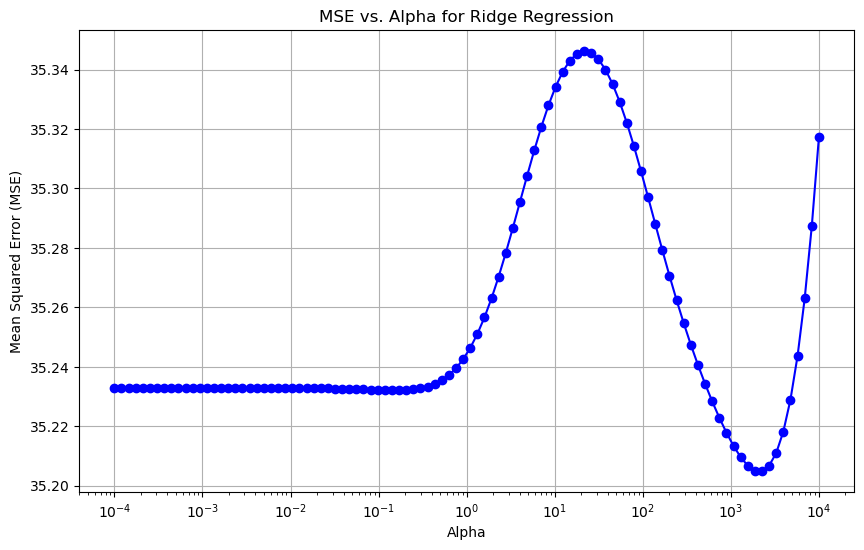

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Alpha for Ridge Regression')
plt.grid(True)
plt.show()

To calculate the final Mean Squared Error (MSE) on the test set using the best alpha value identified from the validation set, we follow the steps ahead. This will give us an estimate of how well your Ridge Regression model is expected to perform on unseen data.

Combine Training and Validation Sets For the final model, you'll use both the training and validation data to train it, maximizing the amount of data the model can learn from.

In [ ]:
# Combine the training and validation sets
X_train_val = np.vstack((Xtrain_1, Xval))
y_train_val = np.concatenate((ytrain_1, yval))

Train the Final Model on the Combined Data Using the best alpha value found, train the Ridge Regression model on the combined training and validation data.

In [ ]:
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train_val, y_train_val)

Ridge(alpha=2257.0197196339213)

Make Predictions on the Test Set and Calculate MSE.

Finally, predict on the test set using the final model and calculate the Mean Squared Error.

In [ ]:
y_test_pred_ridge = final_model.predict(Xtest)  # Predict on the test set
final_test_mse_ridge = mean_squared_error(ytest, y_test_pred_ridge)  # Calculate MSE on the test set
print(f"Training MSE is: {best_mse}") # the mse that you get with the best alpha.
print(f"Final Test MSE: {final_test_mse_ridge}")

Training MSE is: 35.204926351370126
Final Test MSE: 30.493329281334677


c:\Users\Giulia Maria\miniconda3\envs\ML\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


# Lasso

In [ ]:
alphas = np.logspace(-4, 4, 100)

In [ ]:
alpha_values = []
mse_values = []
best_alpha = None
lowest_mse = np.inf

for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(Xtrain_1, ytrain_1)
    y_pred = model.predict(Xval)
    mse = mean_squared_error(yval, y_pred)
    
    alpha_values.append(alpha)
    mse_values.append(mse)
    
    if mse < lowest_mse:
        best_alpha = alpha
        lowest_mse = mse

c:\Users\Giulia Maria\miniconda3\envs\ML\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.306e+05, tolerance: 2.289e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Giulia Maria\miniconda3\envs\ML\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.220e+05, tolerance: 2.289e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Giulia Maria\miniconda3\envs\ML\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

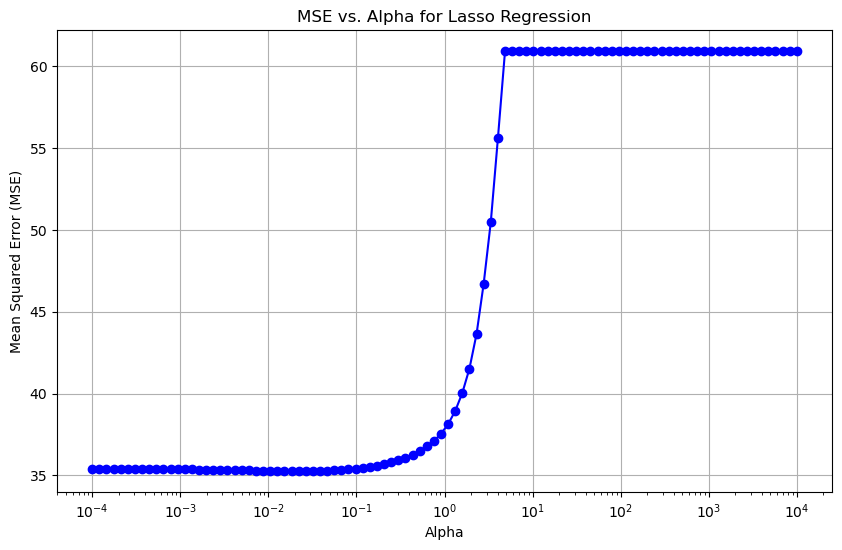

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Alpha for Lasso Regression')
plt.grid(True)
plt.show()

In [ ]:
print(f"Best Alpha: {best_alpha}")
print(f"Lowest MSE: {lowest_mse}")

Best Alpha: 0.015199110829529346
Lowest MSE: 35.26508918404245


In [ ]:
X_train_val = np.vstack((Xtrain_1, Xval))
y_train_val = np.concatenate((ytrain_1, yval))

In [ ]:
final_lasso_model = Lasso(alpha=best_alpha)

In [ ]:
final_lasso_model.fit(X_train_val, y_train_val)

c:\Users\Giulia Maria\miniconda3\envs\ML\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.190e+02, tolerance: 2.714e+02
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.015199110829529346)

In [ ]:
y_test_pred_lasso = final_lasso_model.predict(Xtest)

c:\Users\Giulia Maria\miniconda3\envs\ML\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [ ]:
final_test_mse_lasso = mean_squared_error(ytest, y_test_pred_lasso)

In [ ]:
print(f"Final Test MSE for Lasso: {final_test_mse_lasso}")
print(f"Final Test MSE for Ridge: {final_test_mse_ridge}")

Final Test MSE for Lasso: 30.04719484684103
Final Test MSE for Ridge: 30.493329281334677


## Evaluate the model 


In [ ]:
y_pred = ridge_model.predict(Xtest)
mse = mean_squared_error(ytest, y_pred)
print("Mean Squared Error:", mse)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- -1.026273095114762501e+00
- -1.034039968080203431e-01
- -1.038718893987474967e+00
- -1.041415478909365477e+00
- -1.076766986573888235e-17
- ...
Feature names seen at fit time, yet now missing:
- -1.012904268400146357e+00
- -1.093585797005210747e+00
- -1.128775493232719862e+00
- -1.137421562420412924e+00
- -1.160901497486771961e+00
- ...


Same analysis but with KNN imputed train set 

In [ ]:
Xtrain_KNN, Xval_kNN, ytrain_KNN, yval_KNN = train_test_split(Xtrain_KNN, ytrain, test_size=0.2, random_state=123)
